# Appendix :: Code

## Library Imports

In [3]:
import json
import urllib.request
import sys
import os
import importlib
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib
import bisect
import math
from bs4 import BeautifulSoup
import time
import warnings
import country_converter as coco

In [4]:
#!{sys.executable} -m pip install country_converter

In [5]:
user_module_path = './'
module_path = os.path.abspath(os.path.join(user_module_path))

import fetch_data

## Functions

### Utility functions

In [6]:
def reload_module(module,
                 user_module_path = './'):
    # Block to handle reloading user modules
    module_path = os.path.abspath(os.path.join(user_module_path))
    if module_path not in sys.path:
        sys.path.append(module_path)
    importlib.reload(module)
    fetch_data.test_refresh()

In [7]:
def set_warnings(level):
    # Disable warnings
    warnings.filterwarnings(level)

### Plot functions

In [8]:
def plot_df(df, days=30):
    plt.title("Per day")
    plt.plot(df.index[-days:], df['confirmed'][-days:], label="Confirmed")
    plt.plot(df.index[-days:], df['deaths'][-days:], label="Deaths")
    plt.plot(df.index[-days:], df['recovered'][-days:], label="Recovered")
    plt.legend()
    plt.show()
    
#     plt.title("2nd diff")
#     plt.plot(df.index[-days:], df['confirmed_diff_2'][-days:], label="Confirmed")
#     plt.plot(df.index[-days:], df['deaths_diff_2'][-days:], label="Deaths")
#     plt.plot(df.index[-days:], df['recovered_diff_2'][-days:], label="Recovered")
#     plt.legend()
#     plt.show()

    plt.title("Cumulative, Linear")
    plt.plot(df.index[-days:], df['confirmed_total'][-days:], label="Confirmed")
    plt.plot(df.index[-days:], df['deaths_total'][-days:], label="Deaths")
    plt.plot(df.index[-days:], df['recovered_total'][-days:], label="Recovered")
    plt.legend()
    plt.show()

    plt.title("Cumulative, Log")
    plt.plot(df.index[-days:], df['confirmed_log_total'][-days:], label="Confirmed")
    plt.plot(df.index[-days:], df['deaths_log_total'][-days:], label="Deaths")
    plt.plot(df.index[-days:], df['recovered_log_total'][-days:], label="Recovered")
    plt.legend()
    plt.show()
    
    plt.title("Per day, Log")
    plt.plot(df.index[-days:], df['confirmed_log'][-days:], label="Confirmed")
    plt.plot(df.index[-days:], df['deaths_log'][-days:], label="Deaths")
    plt.plot(df.index[-days:], df['recovered_log'][-days:], label="Recovered")
    plt.legend()
    plt.show()

In [9]:
def plot_set(series,
             panels = 3,
             col_width  = 7,
             row_height = 5,
             fig_title="Title"):
    # Calculate the number of rows
    row_max, col_max, del_cells = calc_maxes(len(series), panels)
    fig, axs = plt.subplots(row_max, col_max)
    fig.set_size_inches(col_max * col_width, row_max * row_height)
    fig.suptitle(fig_title)

    row_idx = 0
    col_idx = 0

    # Handle single row case
    if (row_max == 1):
        for s in series:
            axs[col_idx].plot(s)
            col_idx += 1
    # Multirow case
    else:
        for s in series:
            axs[row_idx, col_idx].plot(s)
            col_idx += 1
            if (col_idx == col_max):
                row_idx += 1
                col_idx = 0

    # Hide extra panels
    offset = col_max - del_cells
    for i in range(0, del_cells):
        axs[row_max-1, offset+i].axis('off')  


In [10]:
def rebase_series(series, threshold=0, ret_idx = False, trim_idx = -1):
    if (trim_idx == -1):
        trim_idx = bisect.bisect_left(series, threshold)
    trim_series = np.array(list(series[trim_idx:].values) + [np.nan]*trim_idx)
    if ret_idx:
        return trim_series, trim_idx
    else:
        return trim_series

In [11]:
def threshold_plot(df,
                   countries,
                   threshold=25,
                   x_lim=45,
                   y_lim=None,
                   log_var = False):
    plt.rcParams.update({'font.size': 14})
    plt.subplots_adjust(wspace=0.4)
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(16, 8)
    fig.suptitle("Cross Country comparisons of growth rates")
    
    plot_var = "deaths_total"
    if log_var:
        threshold = math.log(threshold)
    #plt.figure(figsize=(10,7))
    #plt.title(f"Total coronavirus deaths for places with at least {threshold} deaths")
    
    deaths_threshold = 25
    confirmed_threshold = 1000
    
    #y_ticks = [1, 2000-threshold, 5000-threshold, 20000-threshold]
    #y_tick_labels = [threshold, 2000, 5000, 20000]
#     max_region_st = 0
    for c in countries:
        country_df = df.loc[df["Country/Region"]==c]
        
        deaths_rebase = rebase_series(country_df['deaths_total'], threshold=deaths_threshold)
        axs[0].plot(deaths_rebase-deaths_threshold, label=c)
        
        confirmed_rebase = rebase_series(country_df['confirmed_total'], threshold=confirmed_threshold)
        axs[1].plot(confirmed_rebase-confirmed_threshold, label=c)
#         if region_st > max_region_st:
#             max_region_st = region_st
    #print(f"region_st {len(region_st)}")
        x = np.linspace(0,len(region_st),len(region_st))

        # Add scale lines
    for idx in [0,1]:
        axs[idx].plot(np.power(2,x), color="#666666")
        axs[idx].plot(np.power(2,x/2), color="#666666")
        axs[idx].plot(np.power(2,x/3), color="#666666")
        axs[idx].plot(np.power(2,x/7), color="#666666")
        axs[idx].plot(np.power(2,x/30), color="#666666")
        axs[idx].set_xlim((0,x_lim))
        axs[idx].set_yscale("log", basey=2)                                 
        axs[idx].legend(loc="upper right")                         
        
    axs[0].set_xlabel(f"Days since {deaths_threshold}th death")
    axs[1].set_xlabel(f"Days since {confirmed_threshold}th confirmed case")

    if y_lim is not None:
        axs[0].set_ylim((1,y_lim))
        axs[1].set_ylim((1,y_lim*8))

    axs[0].set_title(f"Total Deaths")
    axs[1].set_title(f"Total Confirmed Cases")

    axs[0].set_yticks([1,100-deaths_threshold,200-deaths_threshold,500-deaths_threshold,
                       1000-deaths_threshold,2000-deaths_threshold,5000-deaths_threshold,
                       10_000-deaths_threshold,20_000-deaths_threshold])
    axs[0].set_yticklabels([deaths_threshold,100,200,500,1000,2000,5000,10_000,20_000])

    axs[1].set_yticks([1,#100-confirmed_threshold,200-confirmed_threshold,500-confirmed_threshold,
                       2000-confirmed_threshold,5000-confirmed_threshold,
                       10_000-confirmed_threshold,20_000-confirmed_threshold,50_000-confirmed_threshold,
                       100_000-confirmed_threshold,200_000-confirmed_threshold,500_000-confirmed_threshold,
                       1_000_000-confirmed_threshold])
    axs[1].set_yticklabels([confirmed_threshold,2000,5000,10_000,20_000,50_000,100_000,
                            200_000,500_000,1_000_000])
    #axs[idx].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.savefig(f'figures/country_set_timeComp_{threshold}.png')
#         plt.show()

In [12]:
def plot_panel(axs, row_idx, col_idx, country_df, plot_vars, threshold, title, log_scale = False, mean_window=1):
    first = True
    for plot_var in plot_vars.keys():
        if first:
            series, trim_idx = rebase_series(country_df[plot_var], threshold=threshold, ret_idx = True)
            first = False
        else:
            series = rebase_series(country_df[plot_var], trim_idx=trim_idx)
        
        series = pd.Series(series).rolling(window=mean_window).mean()
        axs[row_idx, col_idx].plot(series, label=plot_vars[plot_var])
    if log_scale:
        axs[row_idx, col_idx].set_yscale("log", basey=2)                                 
    axs[row_idx, col_idx].set_title(title)
    if row_idx == 1:
        axs[row_idx, col_idx].set_xlabel(f"Days since {threshold}th case")
    axs[row_idx, col_idx].legend(loc='upper left')

In [13]:
def plot_country(full_df, country, threshold, mean_window=3):
    fig, axs = plt.subplots(2, 2)
    plt.rcParams.update({'font.size': 12})
    #plt.subplots_adjust(wspace=0.4,hspace=1.3)
    fig.set_size_inches(16, 10)
    fig.suptitle(f'{country} :: Comparison over time')
    country_df = full_df.loc[full_df["Country/Region"]==country]
    daily_vars = { 'confirmed' : "New Cases",
                 'deaths' : "New Deaths",
                 'recovered' : "New Recovered",
                 'net_cases' : "Net Cases"    
    }
    plot_panel(axs, 0, 0, country_df, daily_vars, threshold, 
               "Daily", mean_window=mean_window)
    plot_panel(axs, 1, 0, country_df, daily_vars, threshold, 
               "Daily (Log)", mean_window=mean_window, log_scale=True)
    cum_vars = { 'confirmed_total' : "Total Confirmed Cases",
                 'deaths_total' : "Total Deaths",
                 'recovered_total' : "Recovered",
                 'active_cases' : "Active Cases"    
    }
    plot_panel(axs, 0, 1, country_df, cum_vars, threshold,
               "Cumulative")
    plot_panel(axs, 1, 1, country_df, cum_vars, threshold,
               "Cumulative (Log)", log_scale=True)
    plt.savefig(f'figures/{country}_timeComp_{threshold}.png')

In [14]:
def plot_country_list(full_df, countries, threshold=25):
    for country in countries:
        plot_country(full_df, country, threshold)

In [15]:
def plot_log_growth(full_df, countries, mean_window=3, days=45):
    #plot_var = 'deaths_log_growth'
    #threshold= 0.5
    # mean_window = 3
    # days = 45

    fig, axs = plt.subplots(1, 2)
    plt.rcParams.update({'font.size': 12})
    #plt.subplots_adjust(wspace=0.4,hspace=1.3)
    fig.set_size_inches(16, 6)

    labels = labels = [i * 15 for i in range(0, days // 15 + 1)]
    for country in countries:
        country_df = full_df.loc[full_df['Country/Region'] == country]
        death_series = country_df['deaths_log_growth'].rolling(window=mean_window).mean()
        confirmed_series = country_df['confirmed_log_growth'].rolling(window=mean_window).mean()
        #series = rebase_series(country_df[plot_var], threshold=threshold)
        axs[0].plot(death_series[-days:], label=country)
        axs[1].plot(confirmed_series[-days:], label=country)
    axs[0].set_title(f'Deaths :: Log Growth (last {days} days)')
    axs[1].set_title(f'Confirmed Cases :: Log Growth (last {days} days)')
    for idx in [0,1]:
        axs[idx].set_xticks(labels)
        axs[idx].set_xticklabels(labels)
    axs[1].legend()
    plt.savefig(f'figures/country_logGrowth_{days}.png')

In [16]:
def plot_normalised(full_df, countries, mean_window=3, days=60):
    fig, axs = plt.subplots(1, 2)
    plt.rcParams.update({'font.size': 12})
    #plt.subplots_adjust(wspace=0.4,hspace=1.3)
    fig.set_size_inches(16, 6)

    labels = [i * 15 for i in range(0, days // 15 + 1)]
    for country in countries:
        country_df = full_df.loc[full_df['Country/Region'] == country]
        death_series = country_df['confirmed_total_norm']
        confirmed_series = country_df['deaths_total_norm']
        #series = rebase_series(country_df[plot_var], threshold=threshold)
        axs[0].plot(death_series[-days:], label=country)
        axs[1].plot(confirmed_series[-days:], label=country)
    axs[0].set_title(f'Deaths, per Million population :: Log Growth (last {days} days)')
    axs[1].set_title(f'Confirmed Cases, per Million population :: Log Growth (last {days} days)')
    for idx in [0,1]:
        axs[idx].set_yscale("log", basey=10) 
        axs[idx].set_xticks(labels)
        axs[idx].set_xticklabels(labels)
    axs[1].legend()
    plt.savefig(f'figures/country_normPop_{days}.png')

## Fetch data

In [184]:
set_warnings('default')

In [185]:
reload_module(fetch_data)

Refreshed at 2020-04-23 19:59:06.315685


In [186]:
full_df, cv_merged_df, iso_codes_df, indicator_df = fetch_data.fetch_all(purge=True)


>> Purging cached files...
	+ Removing file [ assets/full_df.csv ]...
	+ Removing file [ assets/merged_df_global.csv ]...
	+ Removing file [ assets/coronaVirus_global.csv ]...
	+ File [ assets/coronaVirus_US.csv ] not found. Cannot remove...
	+ Removing file [ assets/ISO_codes.csv ]...
	+ Removing file [ assets/wb_indicators.csv ]...
>> File [ merged_df_global.csv ] not found. Fetching...
>> File [ coronaVirus_global.csv ] not found. Fetching...
>> File [ ISO_codes.csv ] not found. Fetching...
>> Before name fixes:
	+ [ Bahamas ] not found...
	+ [ Congo (Brazzaville) ] not found...
	+ [ Congo (Kinshasa) ] not found...
	+ [ Diamond Princess ] not found...
	+ [ Gambia ] not found...
	+ [ Holy See ] not found...
	+ [ Taiwan* ] not found...
	+ [ US ] not found...
	+ [ West Bank and Gaza ] not found...
	+ [ MS Zaandam ] not found...
>> After name fixes:
	+ [ Other ] not found...
>> Before summarise countries:
>> File  [ ISO_codes.csv ] found. Checking age... 
	+ File  [ ISO_codes.csv ] not 

## Scratch coding

In [162]:
full_df['Date'].unique()[-1]

numpy.datetime64('2020-04-22T00:00:00.000000000')

In [183]:
full_df.columns

Index(['Country/Region', 'Province/State', 'ISO3166:2', 'ISO3166:3',
       'ISO3166:#', 'Name', 'Population', 'GDP (Total)',
       'Life Expectancy (Male)', 'Life Expectancy (Female)', 'Date',
       'Confirmed (Total)', 'Deaths (Total)', 'Recovered (Total)',
       'Active (Total)', 'Confirmed (Total, normalised)',
       'Deaths (Total, normalised)', 'Recovered (Total, normalised)',
       'Active (Total, normalised)', 'Confirmed (Total, percent)',
       'Deaths (Total, percent)', 'Recovered (Total, percent)',
       'Active (Total, percent)', 'Confirmed (Daily)', 'Deaths (Daily)',
       'Recovered (Daily)', 'Active (Daily)', 'Confirmed (Daily, normalised)',
       'Deaths (Daily, normalised)', 'Recovered (Daily, normalised)',
       'Active (Daily, normalised)', 'Confirmed (Daily, percent)',
       'Deaths (Daily, percent)', 'Recovered (Daily, percent)',
       'Active (Daily, percent)'],
      dtype='object')

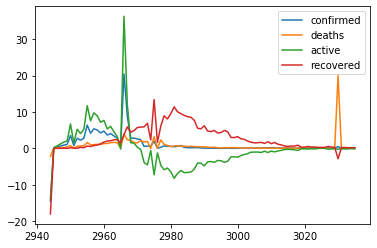

In [182]:
country = "China"
cum = False

typeStr = 'Daily'

confirmed = full_df.loc[full_df['Name']==country, [f'Confirmed ({typeStr}, percent)']]
deaths = full_df.loc[full_df['Name']==country, [f'Deaths ({typeStr}, percent)']]
active = full_df.loc[full_df['Name']==country, [f'Active ({typeStr}, percent)']]
recovered = full_df.loc[full_df['Name']==country, [f'Recovered ({typeStr}, percent)']]

plt.plot(confirmed, label='confirmed')
plt.plot(deaths, label='deaths')
plt.plot(active, label='active')
plt.plot(recovered, label='recovered')
plt.legend()

In [167]:
full_df.loc[(full_df['Date']=='22-04-2020') &
            (full_df['Name'].isin(['China', 'Italy', 'Spain', 'United States']))]

,Country/Region,Province/State,ISO3166:2,ISO3166:3,ISO3166:#,Name,Population,GDP (Total),Life Expectancy (Male),Life Expectancy (Female),...,Recovered (Daily),Active (Daily),"Confirmed (Daily, normalised)","Deaths (Daily, normalised)","Recovered (Daily, normalised)","Active (Daily, normalised)","Confirmed (Daily, percent)","Deaths (Daily, percent)","Recovered (Daily, percent)","Active (Daily, percent)"
3035,China,All,CN,CHN,156,China,1.392730e+09,1.360815e+13,74.549,79.051,...,62.0,-47.0,0.010770,0.000000,0.044517,-0.033747,0.020245,0.000000,0.208249,-0.124047
7083,Italy,All,IT,ITA,380,Italy,6.042176e+07,2.083864e+12,80.800,85.200,...,2943.0,-10.0,55.774608,7.232494,48.707618,-0.165503,4.548277,6.793098,9.885127,-0.026393
12695,Spain,All,ES,ESP,724,Spain,4.679654e+07,1.419042e+12,80.700,86.100,...,3401.0,375.0,89.985285,9.295559,72.676313,8.013413,5.683321,6.762008,11.423485,0.989733
14351,United States,All,US,USA,840,United States,3.266875e+08,2.054434e+13,76.100,81.100,...,2162.0,23338.0,84.603788,6.547542,6.617945,71.438301,37.302616,33.250427,7.261857,61.595714


In [143]:
first = True
for date in list(full_df['Date'].unique()):
    if first:
        world_num = full_df.loc[(full_df['Name']=='World') &
                (full_df['Date']==date), 'Confirmed (Daily)'].values[0]
        deaths = full_df.loc[(full_df['Name']=='World') &
                (full_df['Date']==date), 'Deaths (Daily)'].values[0]
        recovered = full_df.loc[(full_df['Name']=='World') &
                (full_df['Date']==date), 'Confirmed (Daily)'].values[0]
        active = full_df.loc[(full_df['Name']=='World') &
                (full_df['Date']==date), 'Confirmed (Daily)'].values[0]
        first = False
        
print(var)

554.0


In [135]:
full_df.loc[(full_df['Name']=='World'), 'Confirmed (Daily)']

16836      554.0
16837       99.0
16838      287.0
16839      493.0
16840      684.0
          ...   
16923    77522.0
16924    83305.0
16925    71147.0
16926    76978.0
16927    74094.0
Name: Confirmed (Daily), Length: 92, dtype: float64

In [120]:
for col in full_df.columns: print(col)

confirmed_total
deaths_total
recovered_total
Province/State
Country/Region
ISO3166_alpha2
ISO3166_alpha3
ISO3166_numeric
Date
population
gdp_total
lifeExp_male
lifeExp_female
DisplayName
confirmed_daily
deaths_daily
recovered_daily
active_daily
active_total
confirmed_total_norm
deaths_total_norm
recovered_total_norm
active_total_norm
confirmed_daily_norm
deaths_daily_norm
recovered_daily_norm
active_daily_norm


In [103]:
full_df.loc[full_df['Date']=='2020-04-22','DisplayName']

91                 Afghanistan
183                    Albania
275                    Algeria
367                    Andorra
459                     Angola
                 ...          
16559              South Sudan
16651           Western Sahara
16743    Sao Tome and Principe
16835              Yemen, Rep.
16927                    World
Name: DisplayName, Length: 184, dtype: object

In [112]:
new_df = fetch_data.generate_features(full_df)

In [114]:
new_df.loc[new_df['Date']=='2020-04-22']

,confirmed_total,deaths_total,recovered_total,Province/State,Country/Region,ISO3166_alpha2,ISO3166_alpha3,ISO3166_numeric,Date,population,...,active_daily,active_total,confirmed_total_norm,deaths_total_norm,recovered_total_norm,active_total_norm,confirmed_daily_norm,deaths_daily_norm,recovered_daily_norm,active_daily_norm
91,1176.0,40.0,166.0,All,Afghanistan,AF,AFG,004,2020-04-22,3.717239e+07,...,64.0,970.0,3.163639e-05,1.076068e-06,4.465681e-06,2.609464e-05,2.259742e-06,1.076068e-07,4.304270e-07,1.721708e-06
183,634.0,27.0,356.0,All,Albania,AL,ALB,008,2020-04-22,2.866376e+06,...,13.0,251.0,2.211852e-04,9.419560e-06,1.241986e-04,8.756702e-05,8.721815e-06,3.488726e-07,3.837598e-06,4.535344e-06
275,2910.0,402.0,1204.0,All,Algeria,DZ,DZA,012,2020-04-22,4.222843e+07,...,37.0,1304.0,6.891092e-05,9.519653e-06,2.851160e-05,3.087967e-05,2.344392e-06,2.368073e-07,1.231398e-06,8.761870e-07
367,723.0,37.0,309.0,All,Andorra,AD,AND,020,2020-04-22,7.700600e+04,...,-21.0,377.0,9.388879e-03,4.804820e-04,4.012674e-03,4.895722e-03,7.791601e-05,0.000000e+00,3.506220e-04,-2.727060e-04
459,25.0,2.0,6.0,All,Angola,AO,AGO,024,2020-04-22,3.080976e+07,...,1.0,17.0,8.114311e-07,6.491449e-08,1.947435e-07,5.517732e-07,3.245725e-08,0.000000e+00,0.000000e+00,3.245725e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16559,4.0,0.0,0.0,All,South Sudan,SS,SSD,728,2020-04-22,1.097592e+07,...,0.0,4.0,3.644341e-07,0.000000e+00,0.000000e+00,3.644341e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
16651,6.0,0.0,0.0,All,Western Sahara,EH,ESH,732,2020-04-22,NaN,...,0.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16743,4.0,0.0,0.0,All,Sao Tome and Principe,ST,STP,678,2020-04-22,2.110280e+05,...,0.0,4.0,1.895483e-05,0.000000e+00,0.000000e+00,1.895483e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
16835,1.0,0.0,0.0,All,Yemen,YE,YEM,887,2020-04-22,2.849869e+07,...,0.0,1.0,3.508934e-08,0.000000e+00,0.000000e+00,3.508934e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [71]:
full_df.columns

Index(['Country/Region', 'Province/State', 'ISO3166:2', 'ISO3166:3',
       'ISO3166:#', 'Name', 'Population', 'GDP (Total)',
       'Life Expectancy (Male)', 'Life Expectancy (Female)', 'Date',
       'Confirmed (Total)', 'Deaths (Total)', 'Recovered (Total)',
       'Active (Total)', 'Confirmed (Total, normalised)',
       'Deaths (Total, normalised)', 'Recovered (Total, normalised)',
       'Confirmed (Total, log)', 'Deaths (Total, log)',
       'Recovered (Total, log)', 'Confirmed (Daily)', 'Deaths (Daily)',
       'Recovered (Daily)', 'Net Cases (Daily)', 'Confirmed (Daily, log)',
       'Deaths (Daily, log)', 'Recovered (Daily, log)',
       'Confirmed (Daily, log growth)', 'Deaths (Daily, log growth)',
       'Recovered (Daily, log growth)'],
      dtype='object')

In [88]:
search_list = ['United States', 'Belgium', 'Spain', 'Sweden', 'Netherlands']
search_col = 'Name'
reverse_lookup_col_idx(search_list, search_col)

[16, 105, 137, 141, 155]

In [87]:
def reverse_lookup_col_idx(search_list, search_col):
    s = pd.Series(full_df[search_col].unique()).isin(search_list)
    return list(s[s].index)

In [70]:
[print(f"{idx}:{country}") for idx, country in enumerate(full_df['Name'].unique())]


0:Afghanistan
1:Albania
2:Algeria
3:Andorra
4:Angola
5:Antigua and Barbuda
6:Argentina
7:Armenia
8:Australia
9:Austria
10:Azerbaijan
11:Bahamas, The
12:Bahrain
13:Bangladesh
14:Barbados
15:Belarus
16:Belgium
17:Benin
18:Bhutan
19:Bolivia
20:Bosnia and Herzegovina
21:Brazil
22:Brunei Darussalam
23:Bulgaria
24:Burkina Faso
25:Cabo Verde
26:Cambodia
27:Cameroon
28:Canada
29:Central African Republic
30:Chad
31:Chile
32:China
33:Colombia
34:Congo, Rep.
35:Congo, Dem. Rep.
36:Costa Rica
37:Cote d'Ivoire
38:Croatia
39:Cuba
40:Cyprus
41:Czech Republic
42:Denmark
43:Djibouti
44:Dominican Republic
45:Ecuador
46:Egypt, Arab Rep.
47:El Salvador
48:Equatorial Guinea
49:Eritrea
50:Estonia
51:Eswatini
52:Ethiopia
53:Fiji
54:Finland
55:France
56:Gabon
57:Gambia, The
58:Georgia
59:Germany
60:Ghana
61:Greece
62:Guatemala
63:Guinea
64:Guyana
65:Haiti
66:Holy See (Vatican City)
67:Honduras
68:Hungary
69:Iceland
70:India
71:Indonesia
72:Iran, Islamic Rep.
73:Iraq
74:Ireland
75:Israel
76:Italy
77:Jamaica
78

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [60]:
list(full_df.loc[full_df['Name'].isna(), 'ISO3166:3'].unique())

['VAT', 'TWN', 'XKS', 'ESH']

In [64]:
full_df.loc[full_df["ISO3166:3"] == 'XKS', "Country/Region"]

68632    Kosovo
68635    Kosovo
68638    Kosovo
68641    Kosovo
68644    Kosovo
          ...  
68893    Kosovo
68896    Kosovo
68899    Kosovo
68902    Kosovo
68905    Kosovo
Name: Country/Region, Length: 92, dtype: object

In [ ]:
Holy See (Vatican City)
Western Sahara

In [42]:
# full_df.loc[full_df["ISO3166:3"] == 'WLD','DisplayName'] = 'World'

In [48]:
full_df.loc[full_df["ISO3166:3"] == 'WLD','Name']

71392    World
71395    World
71398    World
71401    World
71404    World
         ...  
71653    World
71656    World
71659    World
71662    World
71665    World
Name: Name, Length: 92, dtype: object

In [28]:
# fetch_data.map_name_to_ISOcode('World')

# continents = pd.read_csv('assets/country_continent.csv')

# continents.head()

---
Fetch global corona virus numbers

In [22]:
# PROJECT_FOLDER = '/Users/richie/Dropbox/Records/Education/2019-20_BGSE_MScDataScience/Modules/DS_Trimester02/DataVisualisation/PartB/Project/dashboard/minimal_dash_flask'
# # APP_PATH = "dashboard/minimal_dash_flask/"
# if os.getcwd() != PROJECT_FOLDER:
#     #os.chdir(APP_PATH)
#     os.chdir(PROJECT_FOLDER)
    

In [23]:
os.getcwd()

'/Users/richie/Dropbox/Records/Education/2019-20_BGSE_MScDataScience/Modules/DS_Trimester03/DS_MastersProject/dashboard/cv_dashboard'

In [24]:
# cc  = coco.CountryConverter()

# cc.valid_class

# oecd = set(cc.data.loc[~cc.data['OECD'].isna(),'name_short'])

# other_high_income = set(cc.data.loc[cc.data['Cecilia2050'] == 'HI', 'name_short'])

# eu = cc.data.loc[cc.data['Cecilia2050'] == 'EU', 'name_short']

# other_high_income - oecd

# oecd

# oecd - other_high_income.union(eu)

# cc.data['Cecilia2050'].unique()


# cc.data.columns

# # cc.data.loc[cc.data['Cecilia2050'] == 'EU', 'name_short'] # European Union
# # cc.data.loc[cc.data['Cecilia2050'] == 'HI', 'name_short'] # Other High Income
# # cc.data.loc[cc.data['Cecilia2050'] == 'BX', 'name_short'] # Emerging markets, BRICS+
# # cc.data.loc[cc.data['Cecilia2050'] == 'RoW', 'name_short'] # Rest of World


# # EU : European Union
# # HI : Other High Income
# # BX : Emerging Markets
# # RoW : Rest of World

# cc.OECDas('ISO3')

# cc.EU28as('ISO3')

# # country = 'Afghanistan'
# # m_df = cv_merged_df.copy()

# # first_date = m_df.columns.get_loc("1/22/20")
# # sf = m_df.loc[(m_df['Country/Region'] == country) &
# #                     (m_df['Province/State'].isna())]
# # sf = sf.iloc[:,first_date:].T

# # sf['Country/Region'] = country
# # codes = map_name_to_ISOcode(country)
# # sf['ISO3166_alpha2'] = codes[0]
# # sf['ISO3166_alpha3'] = codes[1]
# # sf['ISO3166_numeric'] = codes[2]

Groups
+ Date
+ Country information
    + Country Name
    + Province / State
    + Continent
    + International Organisation
    + OECD
    + G8
+ Confirmed / Deaths / Recovered / Active
    + Cumulative
    + Delta
    + Cumulative norm
    + Log cumulative
    + Log delta


In [ ]:
# full_df_bak = full_df.copy()

In [ ]:
full_df = full_df_bak.copy()

In [ ]:
full_df

In [ ]:
full_df['Date'] = pd.to_datetime(full_df.index)
full_df.reset_index(inplace=True, drop=True)

In [ ]:
full_df

In [ ]:
full_df.loc[(full_df['Country/Region']=='United States') &
            (full_df['Date']=='2020-04-19')]

In [ ]:
merge_columns = [ 'ISO3166_alpha3', 'population', 'gdp_total',
                  'lifeExp_male', 'lifeExp_female', 'DisplayName']
cv_df = cv_df[merge_columns]
full_df = pd.merge(full_df, cv_df, how='left', on='ISO3166_alpha3')
# Fix the world name
#full_df.loc[full_df["ISO3166_alpha3"] == 'WLD', "Name"] = 'World'


In [ ]:
full_df

In [ ]:
tmp_df3 = full_df.drop_duplicates()

In [ ]:
tmp_df3

In [ ]:
tmp_df3.loc[tmp_df3['ISO3166_alpha3']=='USA']

In [ ]:
for col in cv_merged_df.columns:
    print(col)

In [ ]:
full_df.head()

### Threshold plots

In [ ]:
countries = ['Spain', 'Italy', 'China', 'Korea, South', 'United States', 'Singapore']

# Project

Richard Keely

## Data Sources
For this project, the principal source used was the John Hopkins University's dataset on corona virus cases. This dataset require a surprising amount of cleaning and heavy reshaping to be usable in the form used for this project. In addition, a number of derived statistics were created to allow things like the growth rate and the active statistics to be examined. In addition, to allow for more useful comparisons, I merged it with two additional datasets, the ISO3166 codes available (via some web-scraping) from the CIA World Factbook and then a number of indicators fetched from the World Bank using an API access.

The idea was to make this into an interactive dashboard, but a rather pernicious bug in my caching functions lead to a quite literal 11th hour switch back to static graphics, which are presented below.

## Visualisations and Analysis

In [ ]:
threshold_plot(full_df, countries, y_lim=2**15, x_lim=60)

This plot is a reimplementation of one from the [New York Times' Upshot blog](https://www.nytimes.com/interactive/2020/03/21/upshot/coronavirus-deaths-by-country.html). It allows for a clear view of the growth of the cumulative statistics over time. Here you can see two plots for the countries that I thought would be most interesting to look at, Spain, Italy, China, South Korea, the United States and Singapore (used in all of the plots). Here, it can be seen that the growth rates for most of the countries is now saturating, though the US has not yet reached that point and while Singapore had initially been doing quite well, it appears to now be experiencing a surge in cases.

The code for this plots everything together, so I've inserted the images instead. For all of the plots we can see the daily and cumulative view of our four main variables over time. For the daily variables, a three period rolling average was used to smooth out some of the turbulence caused by the coarseness of the data.

In [ ]:
#plot_country_list(full_df, countries, threshold=25)

![China](figures/China_timeComp_25.png)

The plot for China is the most promising and most similar to the expected theory; after an initial surge, the cases are brought under control and the number of active cases decays towards zero.

![SouthKorea](figures/SouthKorea_timeComp_25.png)

South Korea is also quite promising, showing a similar trend to China, but at an earlier point in the cycle.

![Spain](figures/Spain_timeComp_25.png)

![Italy](figures/Italy_timeComp_25.png)

Spain and Italy appear, unfortunately to be still in the midst of the worst part of the curve. While the net increase in the number of active cases is decreasing, the cumulative case load still hasn't peaked.

![United States](figures/UnitedStates_timeComp_25.png)

The United States is even earlier in the cycle and, indeed merits analysis at a more granular level.

![Singapore](figures/Singapore_timeComp_25.png)

Finally Singapore which had appeared to have missed the worst of the epidemic is now experiencing a surge in cases, though whether this will be as bad as that experienced in Europe and the US remains to be seen.

In [30]:
plot_log_growth(full_df, countries, mean_window=3, days=45)

NameError: name 'countries' is not defined

Next, I looked at the log growth of deaths and confirmed cases over time, again using a rolling average to smooth the noise. Here it can be seen that for most countries the last two weeks have been largely in the right direction after much more volatility before that as reporting and testing likely revealed more of the underlying cases. Interestingly again, Singapore appears to be in a much earlier stage of the cycle.

In [ ]:
plot_normalised(full_df, countries, mean_window=3, days=75)

Finally, here I look at deaths and cases normalised by population, to see get some understanding of the the true toll of the crisis in different countries. One interesting thing from this plot is that while it took time to do so, Spain appears to be doing worse across both the deaths and confirmed cases than Italy. This suggests that Spain may not have been able to capitalise on the time and learning from Italy. In addition, it appears that the US may surpass both Spain and Italy. Here again, Singapore's later entry into the crisis is visible.

---